In [8]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
adata = sc.read('STAG_AML_final.h5ad')

In [3]:
adata.uns['log1p']["base"] = None
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

In [6]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
deg=pd.DataFrame(
    {group + '_' + key[:4]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

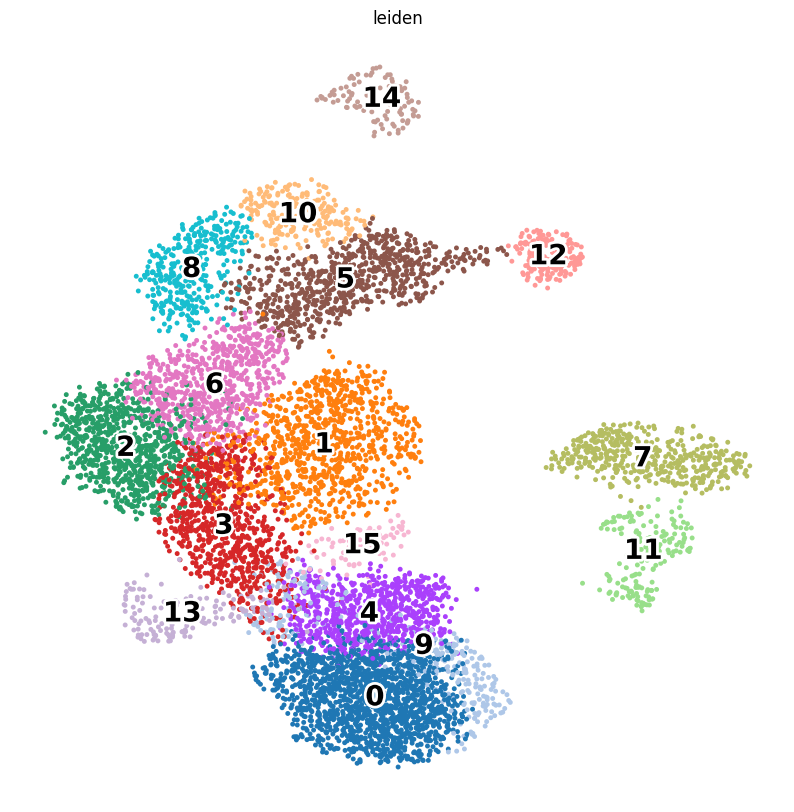

In [9]:
plt.rcParams['figure.figsize'] = (10, 10)
sc.pl.umap(adata, color=['leiden'],s=50,frameon=False,legend_loc='on data',legend_fontsize=20,legend_fontoutline=4)

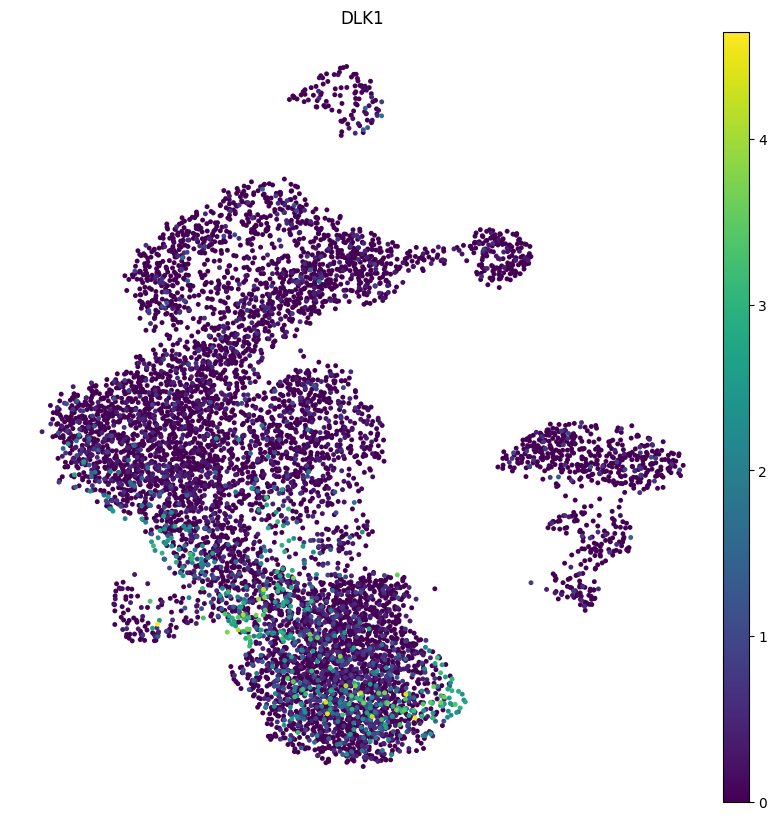

In [15]:
plt.rcParams['figure.figsize'] = (10, 10)
sc.pl.umap(adata, color=['DLK1'],s=50,frameon=False,legend_loc='on data',legend_fontsize=20,legend_fontoutline=4)

In [12]:
i = 9
deg_sub=deg[[f'{i}_name',f'{i}_pval',f'{i}_logf']].copy()
deg_sub['logpval_mult_logf'] = -np.log10(deg_sub[f'{i}_pval']+10**(-300))*np.abs(deg_sub[f'{i}_logf'])

deg_sub = deg_sub[ (deg_sub[f'{i}_pval']<.001) & (deg_sub[f'{i}_logf']>1.5) ].sort_values(by='logpval_mult_logf',ascending=False)
deg_sub.head(40)

,9_name,9_pval,9_logf,logpval_mult_logf
0,CXCL2,1.050899e-96,3.210938,308.180769
1,CXCL3,1.154198e-88,2.677455,235.449283
7,AREG,7.719390e-73,2.920493,210.603784
3,RGS1,1.868284e-83,2.382009,197.060190
6,CXCL1,4.096440e-73,2.344440,169.708385
2,CD74,1.314058e-86,1.677797,144.091497
4,GNA15,1.058300e-81,1.663621,134.712396
8,COBLL1,7.232695e-71,1.905130,133.627128
5,HLA-DPB1,1.429192e-73,1.687922,122.956516
12,GATA2,7.016588e-63,1.821980,113.243115


In [44]:
print(deg_sub[deg_sub.columns[0]].tolist())

['S100A9', 'S100A12', 'S100A8', 'HK3', 'ALOX5', 'FCN1', 'ITGAM', 'S100P', 'CDA', 'OSCAR', 'ALOX5AP', 'CTSH', 'IL18RAP', 'C5AR1', 'PLBD1', 'CXCR2']


In [16]:
leiden_cell={
'0': 'HSC',
'1': 'Proliferating',
'2': 'GMP',
'3': 'GMP',
'4': 'HSC',
'5': 'CD14+CD16+ Mono.',
'6': 'Early monocytes',
'7': 'Naive CD4/CD8 T cell',
'8': 'Neutrophil',
'9': 'HSC',
'10': 'Neutrophil',
'11': 'NK/Eff./Mem. T cell',
'12': 'CD16 Mono.',
'13': 'MEP',
'14': 'Erythrocytes',
'15': 'Proliferating'}

In [17]:
adata.obs['cell_type'] = adata.obs.leiden.apply(lambda x: leiden_cell[x])

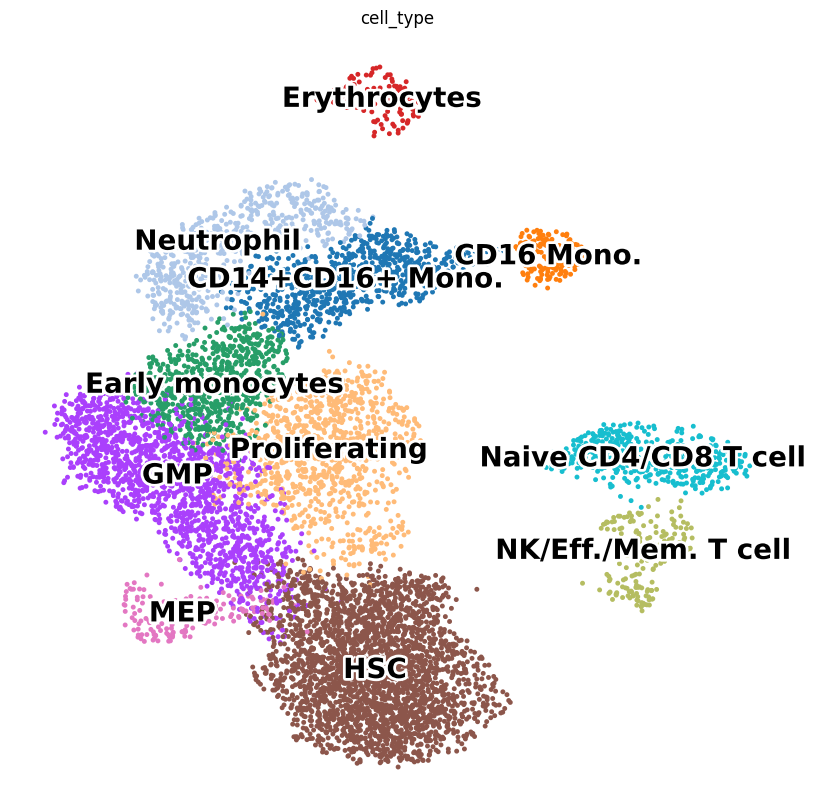

In [18]:
plt.rcParams['figure.figsize'] = (10, 10)
sc.pl.umap(adata, color=['cell_type'],s=50,frameon=False,legend_loc='on data',legend_fontsize=20,legend_fontoutline=4)